## Using the Callbacks System in fast.ai

WNixalo. Code along of [SGugger's notebook](https://github.com/sgugger/Deep-Learning/blob/master/Using%20the%20callback%20system%20in%20fastai.ipynb). 2018/5/11-3

---

The call back system in the fastai library allows you to execute any code at specific times in training. This can be extremely useful if you want to:

- record some parameters (eg: metrics, gradients)
- use a condition to change a parameter (eg: change the learning rate if the validation loss hasn't improved)
- make a schedule of parameters (eg: changing the probabilities of the dropout layers as training progresses)

This notebook shows how to use this code your own callbacks.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Let's experiment on cifar10 and small networks.

In [2]:
from fastai.conv_learner import *
PATH = Path("../data/cifar10/")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([0.4914, 0.48216, 0.44653]), np.array([0.24703, 0.24349, 0.26159]))

In [4]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
size = 32
batch_size = 64

In [6]:
data = get_data(size, batch_size)

I've built a simple fully convolutional neural net. `ks`: kernel size. `re`,`bn`: relu,batch norm flags

In [7]:
def ConvBlock(ch_in, ch_out, ks=3, stride=1, padding=1, re=True, bn=True):
    layers = [nn.Conv2d(ch_in, ch_out, ks, stride=stride, padding=1, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(ch_out))
    if re: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

In [8]:
layers = [ConvBlock(3,  64),
          ConvBlock(64, 64, stride=2), #size 16x16
          ConvBlock(64, 128, stride=2), #size 8x8
          ConvBlock(128, 256, stride=2), #size 4x4
          ConvBlock(256, 10, stride=2), #size 2x2
          nn.AdaptiveAvgPool2d(1), 
          Flatten()]
model = nn.Sequential(*layers)

In [9]:
learn = ConvLearner.from_model_data(model, data)
learn.crit = F.cross_entropy
learn.opt_fn = partial(optim.SGD, momentum=0.9)
learn.metrics = [accuracy]

In [10]:
learn.save('init') # To go back from the first model later.

So what's a callback? Let's have a look at the source code of fastai.

In [11]:
class Callback:
    def on_train_begin(self): pass
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_phase_end(self): pass
    def on_batch_end(self, metrics): pass
    def on_epoch_end(self, metrics): pass
    def on_train_end(self): pass

This class doesn't seem to do anything because it's just a general wrapper. Those 7 functions are all called at a certain point during training. The names are self explanatory, but just in case:

- `on_train_begin` is called at the very beginning of training. Useful to initialize the variables.
- `on_batch_begin` is called before the current batch is passed through the network. It's where you'll want to update training parameters.
- `on_phase_begin` is called at the beginning of each training phase (if you don't use the training API, there's only 1 phase during training). *It's useful if you plan on having different behavior during each phase*.
- `on_phase_end` is called at the end of a training phase.
- `on_batch_end` is called at the end of the batch, with the result of the loss function. It's where you'll wnat to save data or metrics.
- `on_epoch_end` is called at the end of an epoch, after validation, with the validation loss and metrics as an argument.
- `on_train_end` is called at the very end of training.

You customized callback doesn't have to implement those 7 functions since the `Callback` class has them all. So you can code only the ones you want. **NOTE** that you can stop training during `on_batch_end` or `on_epoch_end` by returning `True`, which might be useful!

Let's begin with a simple class that'll record the validation losses. To see what's going on, let's use the easiest way: use the debugger to show us what this `metrics` object contains.

In [12]:
class SaveValidationLoss(Callback):
    def __init__(self):
        self.val_losses = []
    
    def on_epoch_end(self, metrics):
        pdb.set_trace()

First let's find a learning rate.

In [13]:
learn.lr_find(wds=1e-3)

epoch      trn_loss   val_loss   accuracy                   
    0      2.139423   11.282083  0.1363    



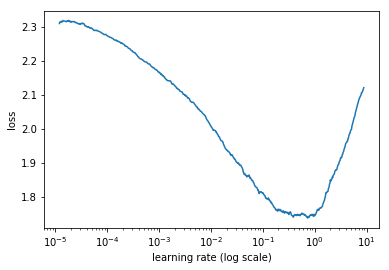

In [14]:
learn.sched.plot()

And let's get something like a 1Cycle to train our network.

In [15]:
def one_cycle(lr, div, lengths, max_mom, min_mom, wds):
    return [TrainingPhase(lengths[0], optim.SGD, lr = (lr/div, lr), lr_decay=DecayType.LINEAR, 
                          momentum = (max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wds),
            TrainingPhase(lengths[1], optim.SGD, lr = (lr, lr/div), lr_decay=DecayType.LINEAR, 
                          momentum = (min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wds),
            TrainingPhase(lengths[2], optim.SGD, lr = lr/div, lr_decay=DecayType.COSINE, 
                          momentum = max_mom, wds=wds)]

To use our callback in the training, we just have to add it in the arguments of `fit`,`fit_opt_sched`:

In [16]:
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[SaveValidationLoss()])

--Return--                                                  
> <ipython-input-12-9aafc4cf57fe>(6)on_epoch_end()->None
-> pdb.set_trace()
(Pdb) metrics
[array([1.2956]), 0.5495]
(Pdb) q


BdbQuit: 

As seen in the debugger, `metrics` contains 2 elements, the first is our validation loss, the second is the accuracy. We can then save it and have a function plot we'll be able to call later to have the graph.

In [17]:
class SaveValidationLoss(Callback):
    def on_train_begin(self):
        self.val_losses = []
    
    def on_epoch_end(self, metrics):
        self.val_losses.append(metrics[0])  ## okay honestly this is so cool
    
    def plot(self):
        plt.plot(list(range(len(self.val_losses))), self.val_losses)

In [18]:
save_val = SaveValidationLoss()

In [19]:
learn.load('init')
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[save_val])

epoch      trn_loss   val_loss   accuracy                   
    0      1.318236   1.225244   0.5825    
    1      1.080519   1.204251   0.5881                     
    2      1.047972   1.048937   0.6399                     
    3      0.983676   0.958261   0.6677                      
    4      0.952155   1.01066    0.6532                      
    5      0.962498   1.224641   0.5835                      
    6      0.957427   0.951709   0.6743                      
    7      0.929046   1.070931   0.635                       
    8      0.927921   0.903167   0.6986                      
    9      0.890742   0.910533   0.6908                      
    10     0.901431   0.889884   0.6926                      
    11     0.9177     0.926473   0.682                       
    12     0.89172    0.842892   0.7054                      
    13     0.88331    0.917995   0.6761                      
    14     0.880893   0.809192   0.7169                      
    15     0.855974   1.07464

[array([0.45258]), 0.8504]

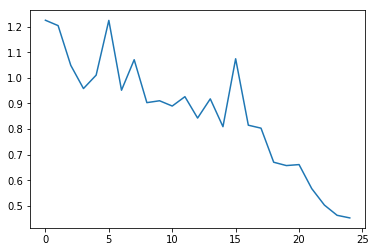

In [20]:
save_val.plot()

People often like to train a neural net with constant learning rates, dividing it automatically if the validation loss doesn't progress. This is easily done with callbacks again: we just have to pass a few arguments:

- the `Learner` object, to be able to modify its learning rate (with `sched.layer_opt.set_lrs`)
- the first learning rate
- the number to divide it

We can even tell hte learner to stop training though the callback by using `return True`. Here we specify a minimum learning rate, and once we're below it we stop.

In [21]:
class LRScheduler(Callback):
    def __init__(self, learn, init_lr, div_lr, min_lr):
        self.learn, self.init_lr, self.div, self.min_lr = learn, init_lr, div_lr, min_lr
        
    def on_train_begin(self):
        self.first_epoch = True
        self.best_loss = 0.
        self.current_lr = self.init_lr
        self.learn.sched.layer_opt.set_lrs(self.current_lr)
        
    def on_epoch_end(self, metrics):
        val_loss = metrics[0]
        if self.first_epoch:
            self.best_loss = val_loss
            self.first_epoch = False
        elif val_loss > self.best_loss:
            self.current_lr /= self.div
            if self.current_lr < self.min_lr: return True
            else: self.learn.sched.layer_opt.set_lrs(self.current_lr)
        else: self.best_loss = val_loss

In [22]:
learn = ConvLearner.from_model_data(model, data)
learn.crit = F.cross_entropy
learn.opt_fn = partial(optim.SGD, momentum=0.9)
learn.metrics = [accuracy]

In [23]:
lr_sched = LRScheduler(learn, 0.1, 10, 1e-4)

In [24]:
learn.load('init')
learn.fit(0.1, 1000, callbacks=[lr_sched]) # Big number in fit to be sure we reach
                                           # the point the learner stops by istelf

epoch      trn_loss   val_loss   accuracy                   
    0      1.235119   1.148155   0.5888    
    1      1.045522   0.94768    0.662                      
    2      0.935658   0.901757   0.6844                      
    3      0.900093   0.799253   0.7182                      
    4      0.803947   0.758536   0.7331                      
    5      0.769984   0.694274   0.7573                      
    6      0.731614   0.64753    0.7752                      
    7      0.683799   0.649156   0.7769                      
    8      0.593121   0.547549   0.8118                      
    9      0.587186   0.532376   0.8169                      
    10     0.588323   0.524654   0.819                       
    11     0.573139   0.517256   0.8229                      
    12     0.561351   0.511775   0.8253                      
    13     0.534554   0.508939   0.8252                      
    14     0.519847   0.505422   0.8263                      
    15     0.545192   0.5013

[array([0.4913]), 0.8324]

Me: *this is so fucking cool.*

**Note** that this wasn't as efficient as a 1-Cycle in this situation. (**0.491302** best val_loss vs **0.452584** in 1-Cycle)

Now let's see how we can have the dropout probability change through training. We could begin with 0 and slowly increase to a maximum value. First, let's add some dropout in the model (**Note** that's just for the sake of showing how to do it since we weren't overfitting before, so dropout probably won't help much).

In [25]:
layers = [ConvBlock(3, 64),
          ConvBlock(64, 64, stride=2), # size 16x16
          ConvBlock(64, 128, stride=2), # size 8x8
          ConvBlock(128, 256, stride=2), # size 4x4
          nn.Dropout(0.2), 
          ConvBlock(256, 10, stride=2), # size 2x2
          nn.AdaptiveAvgPool2d(1), 
          Flatten()]
model = nn.Sequential(*layers)

Then we identify where it is in the model:

In [26]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
  )
  (4): Dropout(p=0.2)
  (5): Sequential(
    (0): Conv2d(256, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True)
    (2):

It's the layer of index 4. We can access the `p` of the dropout by `model[4].p`.

In [27]:
model[4].p

0.2

That's all we need to create our dropout scheduler! I'll use the class `DecayScheduler` to have something giving me the values going from 0 to the max. It's the one that's used to create the `lr_decay` or `momentum_decay` in the new training API.

It's fairly simple: you specify a decay type (linear, exponential, ...), a number of iterations, a min value and a max value, then you just have to call `next_val` each time you want to update your parameter.

In [28]:
nb_batches = len(data.trn_dl)

We need the number of batches to give our `DecayScheduler` the number of iterations, then we just update the `p` value accordingly. We have a list of schedulers, one for each phase, so we also update the index of the current phase.

In [29]:
class DropoutScheduler(Callback):
    def __init__(self, dp, scheds):
        self.dp = dp
        self.phase = 0
        self.scheds = scheds
    
    def on_train_begin(self):
        self.phase = 0
    
    def on_phase_begin(self):
        self.sched = self.scheds[self.phase]
    
    def on_phase_end(self):
        self.phase += 1
    
    def on_batch_begin(self):
        self.dp.p = self.sched.next_val()

In [30]:
dp_phases = [DecayScheduler(DecayType.LINEAR, nb_batches*10, 0, 0.1), # 1st phase: go from 0 to 0.1
             DecayScheduler(DecayType.LINEAR, nb_batches*10, 0, 0.2), # 2nd phase: from 0.1 to 0.2
             DecayScheduler(DecayType.NO, nb_batches*5, 0.2),]        # then stay at 0.2

In [31]:
dp_sched = DropoutScheduler(learn.model[4], dp_phases)

In [32]:
learn.load('init')
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[save_val])

epoch      trn_loss   val_loss   accuracy                   
    0      1.331589   1.385748   0.5199    
    1      1.121358   1.062009   0.6282                     
    2      1.044424   1.011629   0.642                      
    3      0.988567   1.171273   0.6071                      
    4      0.979917   0.961783   0.6679                      
    5      0.924612   1.191611   0.6013                      
    6      0.931573   1.001064   0.6557                      
    7      0.890444   0.920378   0.6839                      
    8      0.937574   0.897663   0.691                       
    9      0.915426   1.030292   0.6296                      
    10     0.897371   0.896589   0.6963                      
    11     0.906785   0.849947   0.7099                      
    12     0.896768   0.954596   0.6689                      
    13     0.878765   0.89472    0.6899                      
    14     0.857661   1.041596   0.6563                      
    15     0.830335   0.82144

[array([0.45944]), 0.8508]

## End

---